# Pyplearnr demo
Here I demonstrate pyplearnr, a wrapper for scikit-learn that performs model validation and selection using nested k-fold cross-validation.

# Titanic dataset example
Here I use the Titanic dataset I've cleaned and pickled in a separate tutorial.

# Prepare data
## Import data

In [1]:
import os

import pandas as pd
import numpy as np

In [2]:
df = pd.read_pickle('trimmed_titanic_data.pkl')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 9 columns):
Survived    890 non-null int64
Pclass      890 non-null int64
Sex         890 non-null object
Age         890 non-null float64
SibSp       890 non-null int64
Parch       890 non-null int64
Fare        890 non-null float64
Embarked    890 non-null object
Title       890 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


By "cleaned" I mean I've derived titles (e.g. "Mr.", "Mrs.", "Dr.", etc) from the passenger names, imputed the missing Age values using polynomial regression with grid-searched 10-fold cross-validation, filled in the 3 missing Embarked values with the mode, and removed all fields that could be considered an id for that individual.

Thus, no data are missing or null.

## Set categorical features as type 'category'
In order to one-hot encode categorical data, its best to set the features that are considered categorical:

In [3]:
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.000000,1,0,7.2500,S,Mr
1,1,1,female,38.000000,1,0,71.2833,C,Mrs
2,1,3,female,26.000000,0,0,7.9250,S,Miss
3,1,1,female,35.000000,1,0,53.1000,S,Mrs
4,0,3,male,35.000000,0,0,8.0500,S,Mr
5,0,3,male,35.050324,0,0,8.4583,Q,Mr
6,0,1,male,54.000000,0,0,51.8625,S,Mr
7,0,3,male,2.000000,3,1,21.0750,S,Child
8,1,3,female,27.000000,0,2,11.1333,S,Mrs
9,1,2,female,14.000000,1,0,30.0708,C,Mrs


In [4]:
simulation_df = df.copy()

categorical_features = ['Survived','Pclass','Sex','Embarked','Title']

for feature in categorical_features:
    simulation_df[feature] = simulation_df[feature].astype('category')
    
simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 9 columns):
Survived    890 non-null category
Pclass      890 non-null category
Sex         890 non-null category
Age         890 non-null float64
SibSp       890 non-null int64
Parch       890 non-null int64
Fare        890 non-null float64
Embarked    890 non-null category
Title       890 non-null category
dtypes: category(5), float64(2), int64(2)
memory usage: 39.9 KB


## One-hot encode categorical features

In [5]:
simulation_df = pd.get_dummies(simulation_df,drop_first=True)

simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 17 columns):
Age               890 non-null float64
SibSp             890 non-null int64
Parch             890 non-null int64
Fare              890 non-null float64
Survived_1        890 non-null uint8
Pclass_2          890 non-null uint8
Pclass_3          890 non-null uint8
Sex_male          890 non-null uint8
Embarked_Q        890 non-null uint8
Embarked_S        890 non-null uint8
Title_Dr          890 non-null uint8
Title_Military    890 non-null uint8
Title_Miss        890 non-null uint8
Title_Mr          890 non-null uint8
Title_Mrs         890 non-null uint8
Title_Noble       890 non-null uint8
Title_Rev         890 non-null uint8
dtypes: float64(2), int64(2), uint8(13)
memory usage: 46.1 KB


Now we have 17 features.

## Split into input/output data

In [6]:
# Set output feature
output_feature = 'Survived_1'

# Get all column names
column_names = list(simulation_df.columns)

# Get input features
input_features = [x for x in column_names if x != output_feature]

# Split into features and responses
X = simulation_df[input_features].copy()
y = simulation_df[output_feature].copy()

# Null model

In [7]:
simulation_df['Survived_1'].value_counts().values/float(simulation_df['Survived_1'].value_counts().values.sum())

array([ 0.61573034,  0.38426966])

Thus, null accuracy of ~62% if we always predict death.

# Import pyplearnr and initialize optimized pipeline collection

In [8]:
%matplotlib inline

import pyplearnr as ppl

# KNN 
Here we do a k-nearest neighbors (KNN) classification with stratified and nested 3-by-3-fold cross-validation over the 1 to 30 nearest neighbors and the use of either "uniform" or "distance" weights:

In [9]:
%%time 

# Initialize nested k-fold cross-validation object
kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=3, 
                                      inner_loop_fold_count=3,
                                      shuffle_seed=2369,
                                      outer_loop_split_seed=461,
                                      inner_loop_split_seeds=[284, 406, 303])

# Combinatorial pipeline schematic
pipeline_schematic = [
    {'estimator': {
            'knn': {
                'n_neighbors': range(1,31),
                'weights': ['uniform','distance']
    }}}
]

# Perform nested k-fold cross-validation
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, 
         scoring_metric='auc', score_type='median')

Outer Fold: 2 

51 Pipeline(steps=[('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=26, p=2,
           weights='distance'))])
55 Pipeline(steps=[('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=28, p=2,
           weights='distance'))])


No model was chosen because there is no clear winner. Please use the same fit method with best_inner_fold_pipeline_inds keyword argument.

Example:	kfcv.fit(X.values, y.values, pipelines)
		kfcv.fit(X.values, y.values, pipelines, 
			 best_inner_fold_pipeline_inds = {0:9, 2:3})

CPU times: user 5.72 s, sys: 91.6 ms, total: 5.81 s
Wall time: 5.96 s


Pyplearnr has indicated that the contest of outer-fold 2 has resulted in a tie between two pipelines with the same median score over all inner-folds. We can resolve this by re-running the fit method with the best_inner_fold_pipeline_inds keyword argument. I'll choose the simplest (higher number of neighbors):

In [10]:
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, 
         best_inner_fold_pipeline_inds={2:55})

55 Pipeline(steps=[('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=28, p=2,
           weights='distance'))])
21 Pipeline(steps=[('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='distance'))])
31 Pipeline(steps=[('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=16, p=2,
           weights='distance'))])


No model was chosen because there is no clear winner. Please use the same fit method with one of the indices above.

Example:	kfcv.fit(X.values, y.values, pipelines)
		kfcv.fit(X.values, y.values, pipelines, best_outer_fold_pipeline=9)


Whatever pipline wins the most outer-fold contests wins overall.

In this case, pyplearnr has notified us that all inner-fold contests of each outer-fold have resulted in different winners. We can resolve this conflict by, again, re-running the fit method, but with the best_outer_fold_pipeline keyword argument:

In [11]:
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, 
         best_outer_fold_pipeline=55)


--------------------------------------------------------------------------------
Best pipeline: 55
--------------------------------------------------------------------------------
----------------------  ------------------------------------
Validation performance  Inner-loop scores
----------------------  ------------------------------------
                                    OF0       OF1       OF2
 min    0.6582            min    0.6749     0.669    0.6558
 25%    0.6621            25%    0.6752    0.6956     0.673
 50%    0.6659            50%    0.6755    0.7222    0.6903
 75%    0.6903            75%    0.6911    0.7296    0.7149
 max    0.7146            max    0.7066    0.7371    0.7395
----------------------  ------------------------------------
mean    0.6796           mean    0.6857    0.7094    0.6952
 std   0.03059            std   0.01818   0.03576   0.04207
----------------------  ------------------------------------
 OF0    0.7146            IF0    0.6755    0.7222    

The output report lists the winning pipeline index, its validation (outer-fold test) scores and statistics, inner-fold (IF) test scores and statistics for each outer-fold (OF), a layout of the pipeline steps, and the corresponding step parameters.

Additionally, the report contains the outer- and inner-fold counts, seeds, scoring metric, and scoring type. These, along with the same data and pipelines, can be used as inputs to the nested k-fold cross-validation object initialization and its fit method to uniquely duplicate the results of this run.

We can get a visual report of this pipeline's validation scores and the inner-fold test scores for each outer-fold:

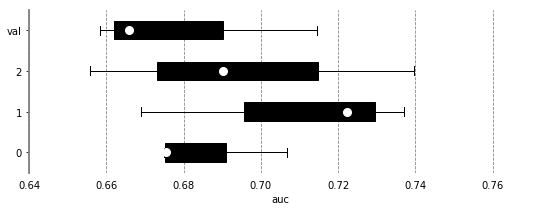

In [12]:
kfcv.plot_best_pipeline_scores()

Additionally we can visualize the performance of all pipelines over all folds:

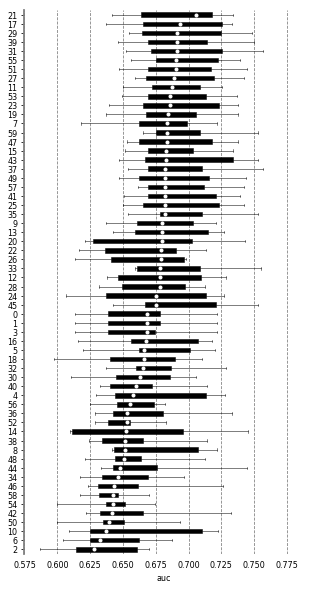

In [13]:
kfcv.plot_contest(all_folds=True, markersize=3, figsize=(5,10), fontsize=8)

Additionally, we can visualize the test fold scores in all folds separately:

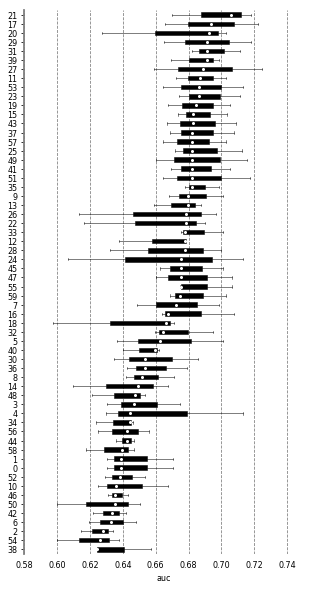

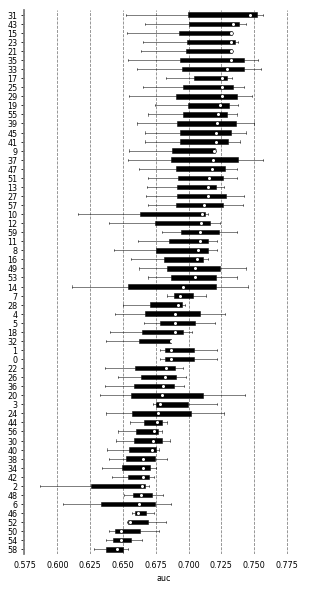

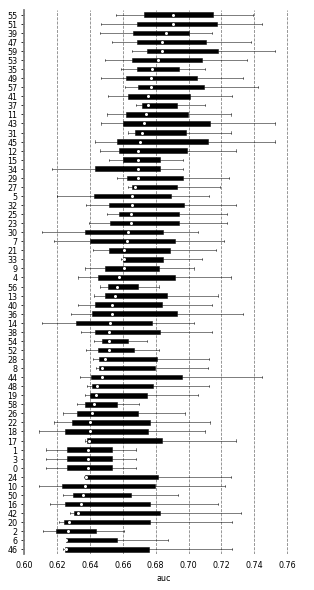

In [14]:
kfcv.plot_contest(markersize=2, figsize=(5,10), fontsize=8)

# KNN with different scaling
We can investigate how scaling affects the scores for this dataset by including them in the combinatorial pipeline schematic:

In [15]:
%%time 

# Initialize nested k-fold cross-validation object
kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=3, 
                                      inner_loop_fold_count=3,
                                      shuffle_seed=2369,
                                      outer_loop_split_seed=461,
                                      inner_loop_split_seeds=[284, 406, 303])

# Combinatorial pipeline schematic
pipeline_schematic = [
    {'scaler': {
            'none': {},
            'standard': {},
            'normal': {},
            'min_max': {},
            'binary': {}
        }},
    {'estimator': {
            'knn': {
                'n_neighbors': range(1,31),
                'weights': ['uniform','distance']
    }}}
]

# Perform nested k-fold cross-validation
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, 
         scoring_metric='auc', score_type='median')

Outer Fold: 1 

11 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='distance'))])
13 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='distance'))])
15 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='distance'))])


No model was chosen because there is no clear winner. Please use the same fit method with best_inner_fold_pipeline_inds keyword argument.

Example:	kfcv.fit(X.values, y.values, pipelines)
		kfcv.fit(X.v

In [16]:
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, 
         scoring_metric='auc', score_type='median',
         best_inner_fold_pipeline_inds={1:15})

248 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
27 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=14, p=2,
           weights='distance'))])
15 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='distance'))])


No model was chosen because there is no clear winner. Please use the same fit method with one of the indices above.

Example:	kfcv.fit(X.values, y.values, pipelines)
		kfcv.fit(X.values, y.values, pipelines

In [18]:
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, 
         scoring_metric='auc', score_type='median',
         best_outer_fold_pipeline=27)


--------------------------------------------------------------------------------
Best pipeline: 27
--------------------------------------------------------------------------------
----------------------  ------------------------------------
Validation performance  Inner-loop scores
----------------------  ------------------------------------
                                    OF0       OF1       OF2
 min    0.7387            min    0.7461    0.7735    0.7445
 25%    0.7624            25%    0.7627    0.7894    0.7708
 50%    0.7861            50%    0.7792    0.8053    0.7971
 75%     0.798            75%    0.7931    0.8291    0.7976
 max      0.81            max    0.8069    0.8529     0.798
----------------------  ------------------------------------
mean    0.7783           mean    0.7774    0.8106    0.7799
 std   0.03629            std   0.03045   0.03993   0.03064
----------------------  ------------------------------------
 OF0      0.81            IF0    0.7461    0.8053    

Pyplearnr has chosen a pipeline that scales the feature data to between 0 and 1 before putting it through a KNN classifier set to consider 14 nearest neighbors weighted by distance.

We can plot the contests again, but this time with the color_by keyword argument, to see if there are any patterns:

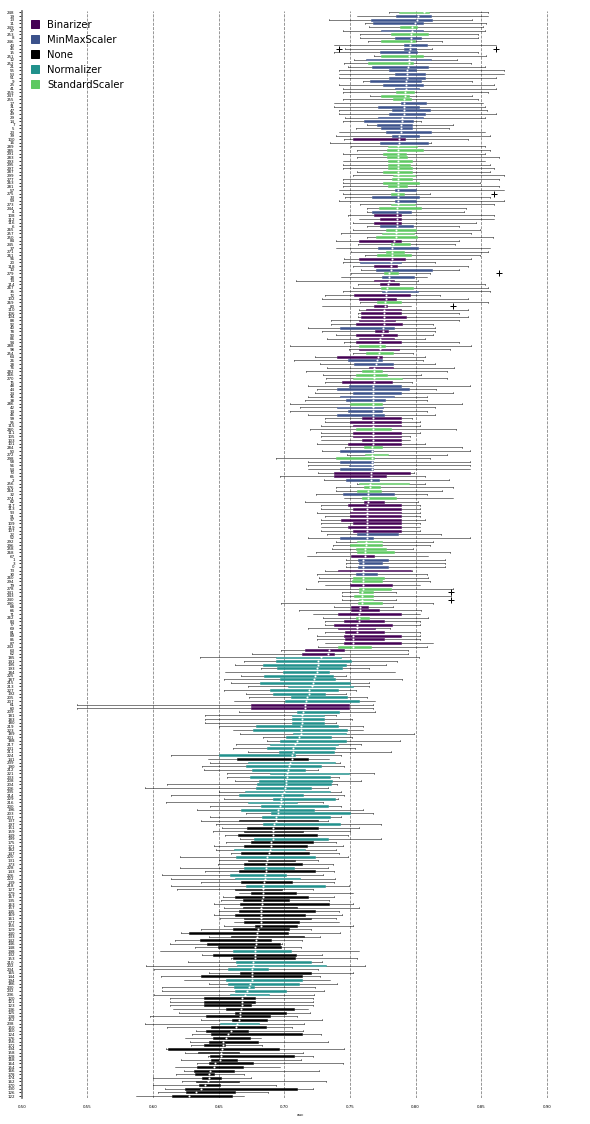

In [19]:
kfcv.plot_contest(color_by='scaler', all_folds=True, 
                  markersize=1, figsize=(10,20), fontsize=4)

As expected, those pipelines with a lack of scaling have the lowest scores. Additionally, the scikit-learn Normalizer scaler does worse than the others. 

The MinMaxScaler and StandardScaler do the best for this dataset with the KNN classifier.

# Different estimators
Let's say we would like to compare the performance of multiple classifiers on this dataset. We can specify scikit-learn objects directly if they're not already supported by including them as a 'sklo' parameter for step options:

In [28]:
%%time 

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Initialize nested k-fold cross-validation object
kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=3, 
                                      inner_loop_fold_count=3,
                                      shuffle_seed=2369,
                                      outer_loop_split_seed=461,
                                      inner_loop_split_seeds=[284, 406, 303])

# Combinatorial pipeline schematic
pipeline_schematic = [
    {'estimator': {
            'knn': {
                'n_neighbors': range(1,31),
                'weights': ['uniform','distance']
            },
            'svm': {
                    'sklo': LinearSVC,
                    'loss': ['hinge', 'squared_hinge']
                },
            'logistic_regression': {
                'random_state': [65]
            },
            'random_forest': {
                'sklo': RandomForestClassifier,
                'max_depth': range(2,6),
                'random_state': [57]
            },
            'gaussian': {
                'sklo': GaussianProcessClassifier,                
            },
            'adaboost': {
                'sklo': AdaBoostClassifier
            },
            'naive_bayes': {
                'sklo': GaussianNB
            },
            'qda': {
                'sklo': QuadraticDiscriminantAnalysis
            }
    }}
]

# Perform nested k-fold cross-validation
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, 
         scoring_metric='auc', score_type='median')

Outer Fold: 2 

60 Pipeline(steps=[('estimator', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=65, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
63 Pipeline(steps=[('estimator', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])


No model was chosen because there is no clear winner. Please use the same fit method with best_inner_fold_pipeline_inds keyword argument.

Example:	kfcv.fit(X.values, y.values, pipelines)
		kfcv.fit(X.values, y.values, pipelines, 
			 best_inner_fold_pipeline_inds = {0:9, 2:3})

CPU times: user 11.9 s, sys: 717 ms, total: 12.6 s
Wall time: 10.7 s


Note how I've set the random_state kwarg for RandomForestClassifier and logistic_regression to control their behavior so these results are repeatable. It's good practice to have a random number generator set seeds and then to save them where needed for debugging and such.

I think normal logistic regression is "simpler" than the result of AdaBoostClassifier:

In [29]:
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, 
    best_inner_fold_pipeline_inds={2:60})


--------------------------------------------------------------------------------
Best pipeline: 60
--------------------------------------------------------------------------------
----------------------  ------------------------------------
Validation performance  Inner-loop scores
----------------------  ------------------------------------
                                    OF0       OF1       OF2
 min    0.7673            min     0.779    0.7947    0.7733
 25%    0.7856            25%    0.7955    0.8076    0.7799
 50%    0.8039            50%    0.8119    0.8205    0.7865
 75%    0.8167            75%    0.8129    0.8351    0.7946
 max    0.8294            max    0.8139    0.8497    0.8027
----------------------  ------------------------------------
mean    0.8002           mean    0.8016    0.8216    0.7875
 std   0.03123            std   0.01961   0.02752   0.01475
----------------------  ------------------------------------
 OF0    0.8039            IF0     0.779    0.7947    

The best model appears to be logistic regression.

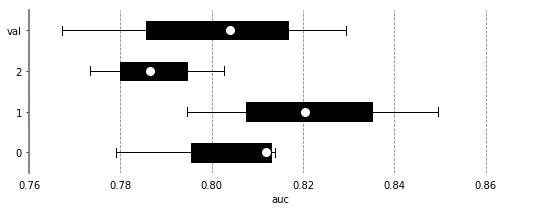

In [30]:
kfcv.plot_best_pipeline_scores()

The validation performance matches well with that in the inner-fold contests.

Let's look at all of the inner-fold pipeline contests:

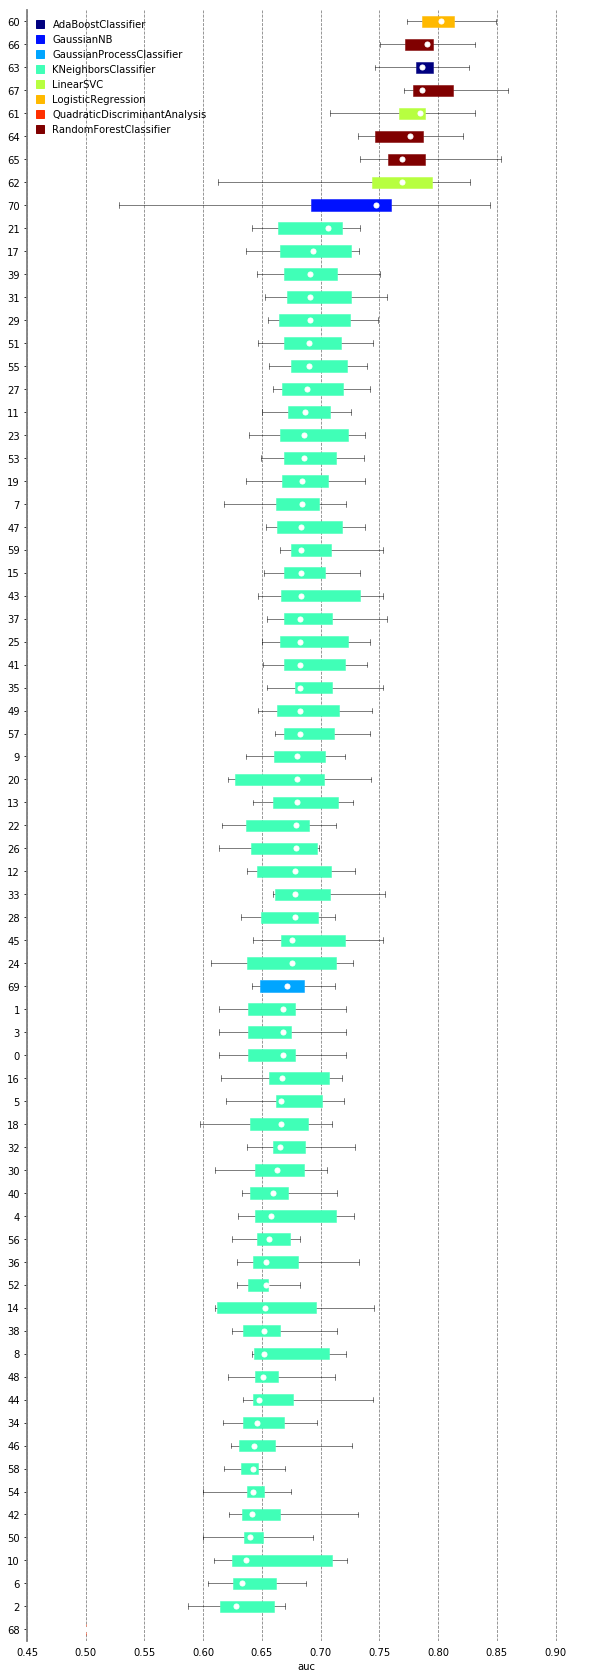

In [31]:
kfcv.plot_contest(all_folds=True, color_by='estimator', 
                  color_map='jet', markersize=5, fontsize=10)

Note, I've chosen different input parameters to make the plot look better.

# PCA with feature selection and KNN
We'd like to see if there's any pattern in doing either standard or min_max scaling, PCA, selection of different numbers of the transformed output (essentially selecting the number of principal components to use to transform the data), and k-nearest neighbors over multiple values of k:

In [32]:
%%time 

import numpy as np

# Initialize nested k-fold cross-validation object
kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=3, 
                                      inner_loop_fold_count=3,
                                      shuffle_seed=3243,
                                      outer_loop_split_seed=45,
                                      inner_loop_split_seeds=[62, 207, 516])

# Combinatorial pipeline schematic
feature_count = X.shape[1]

pipeline_schematic = [
    {'scaler': {
            'min_max': {},
            'standard': {}
        }
    },
    {'transform': {
            'pca': {
                'n_components': [feature_count]
            }
        }         
    },
    {'feature_selection': {
            'select_k_best': {
                'k': range(1, feature_count+1)
            }
        }
    },
    {'estimator': {
            'knn': {
                'n_neighbors': range(1,31)
                }
        }
    }
]

# Perform nested k-fold cross-validation
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, scoring_metric='auc')

184 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('transform', PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('feature_selection', SelectKBest(k=7, score_func=<function f_classif at 0x11a0209b0>)), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
728 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('transform', PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('feature_selection', SelectKBest(k=9, score_func=<function f_classif at 0x11a0209b0>)), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform'))])
932 Pipeline(steps=[('s

In [33]:
kfcv.fit(X.values, y.values, 
         pipeline_schematic=pipeline_schematic, 
         best_outer_fold_pipeline=728)


--------------------------------------------------------------------------------
Best pipeline: 728
--------------------------------------------------------------------------------
----------------------  ------------------------------------
Validation performance  Inner-loop scores
----------------------  ------------------------------------
                                    OF0       OF1       OF2
 min    0.7789            min     0.761    0.7733    0.7757
 25%    0.7892            25%    0.7667    0.8012    0.7888
 50%    0.7995            50%    0.7724    0.8291     0.802
 75%    0.8042            75%     0.782    0.8293    0.8073
 max    0.8089            max    0.7916    0.8295    0.8127
----------------------  ------------------------------------
mean    0.7958           mean     0.775    0.8106    0.7968
 std   0.01533            std   0.01546   0.03234   0.01904
----------------------  ------------------------------------
 OF0    0.8089            IF0    0.7724    0.8291   

Our process has resulted in the selection of a pipeline with standard scaling, PCA, selection of 9 principal components, and feeding into a KNN classifier with 9 neighbors and use of unform weighting.

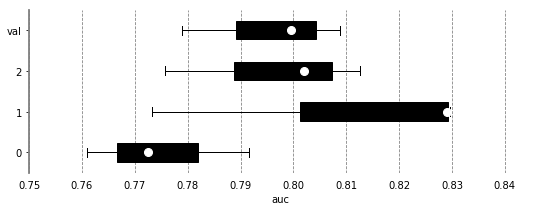

In [34]:
kfcv.plot_best_pipeline_scores()

The validation performance is in line with the best pipeline's inner-fold testing performance for each outer-fold.

We can look at the effect of parameter values by changing the color_by keyword argument to a string with the format 
'step\__step_option\__parameter_name\__parameter_value'. To be clear, those are two underscores in-between step, step_options, parameter_name, and parameter_value

Let's see if there are any patterns with regard to the number of principal components used:

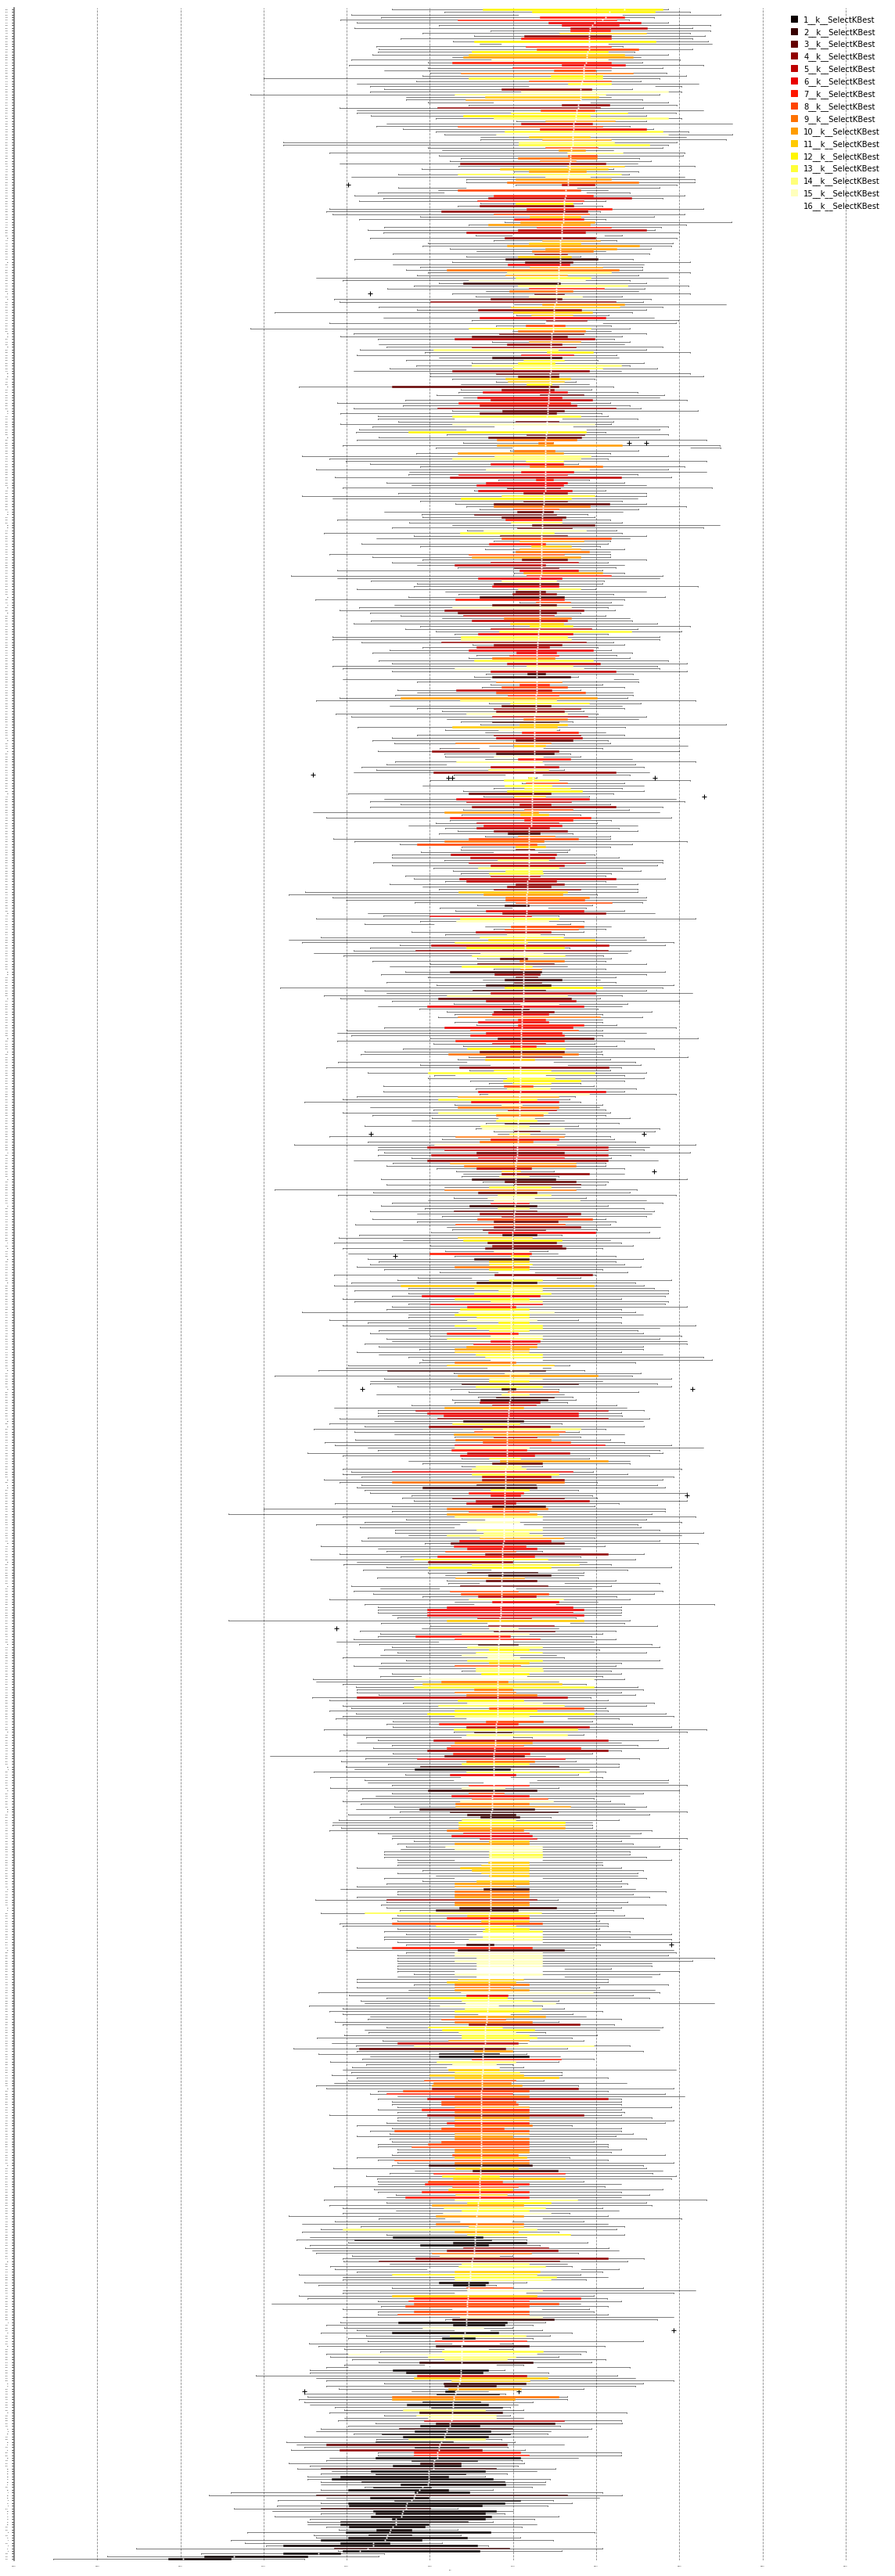

In [35]:
kfcv.plot_contest(all_folds=True, markersize=1, fontsize=2, figsize=(20,60), 
                  color_by='feature_selection__select_k_best__k', color_map='hot')

Not sure I see much of a pattern other than the lower numbers of principal components used to transform the data tends to predominate at the lowest scores.

Now let's look at the number of k-nearest neighbors for the classifier:

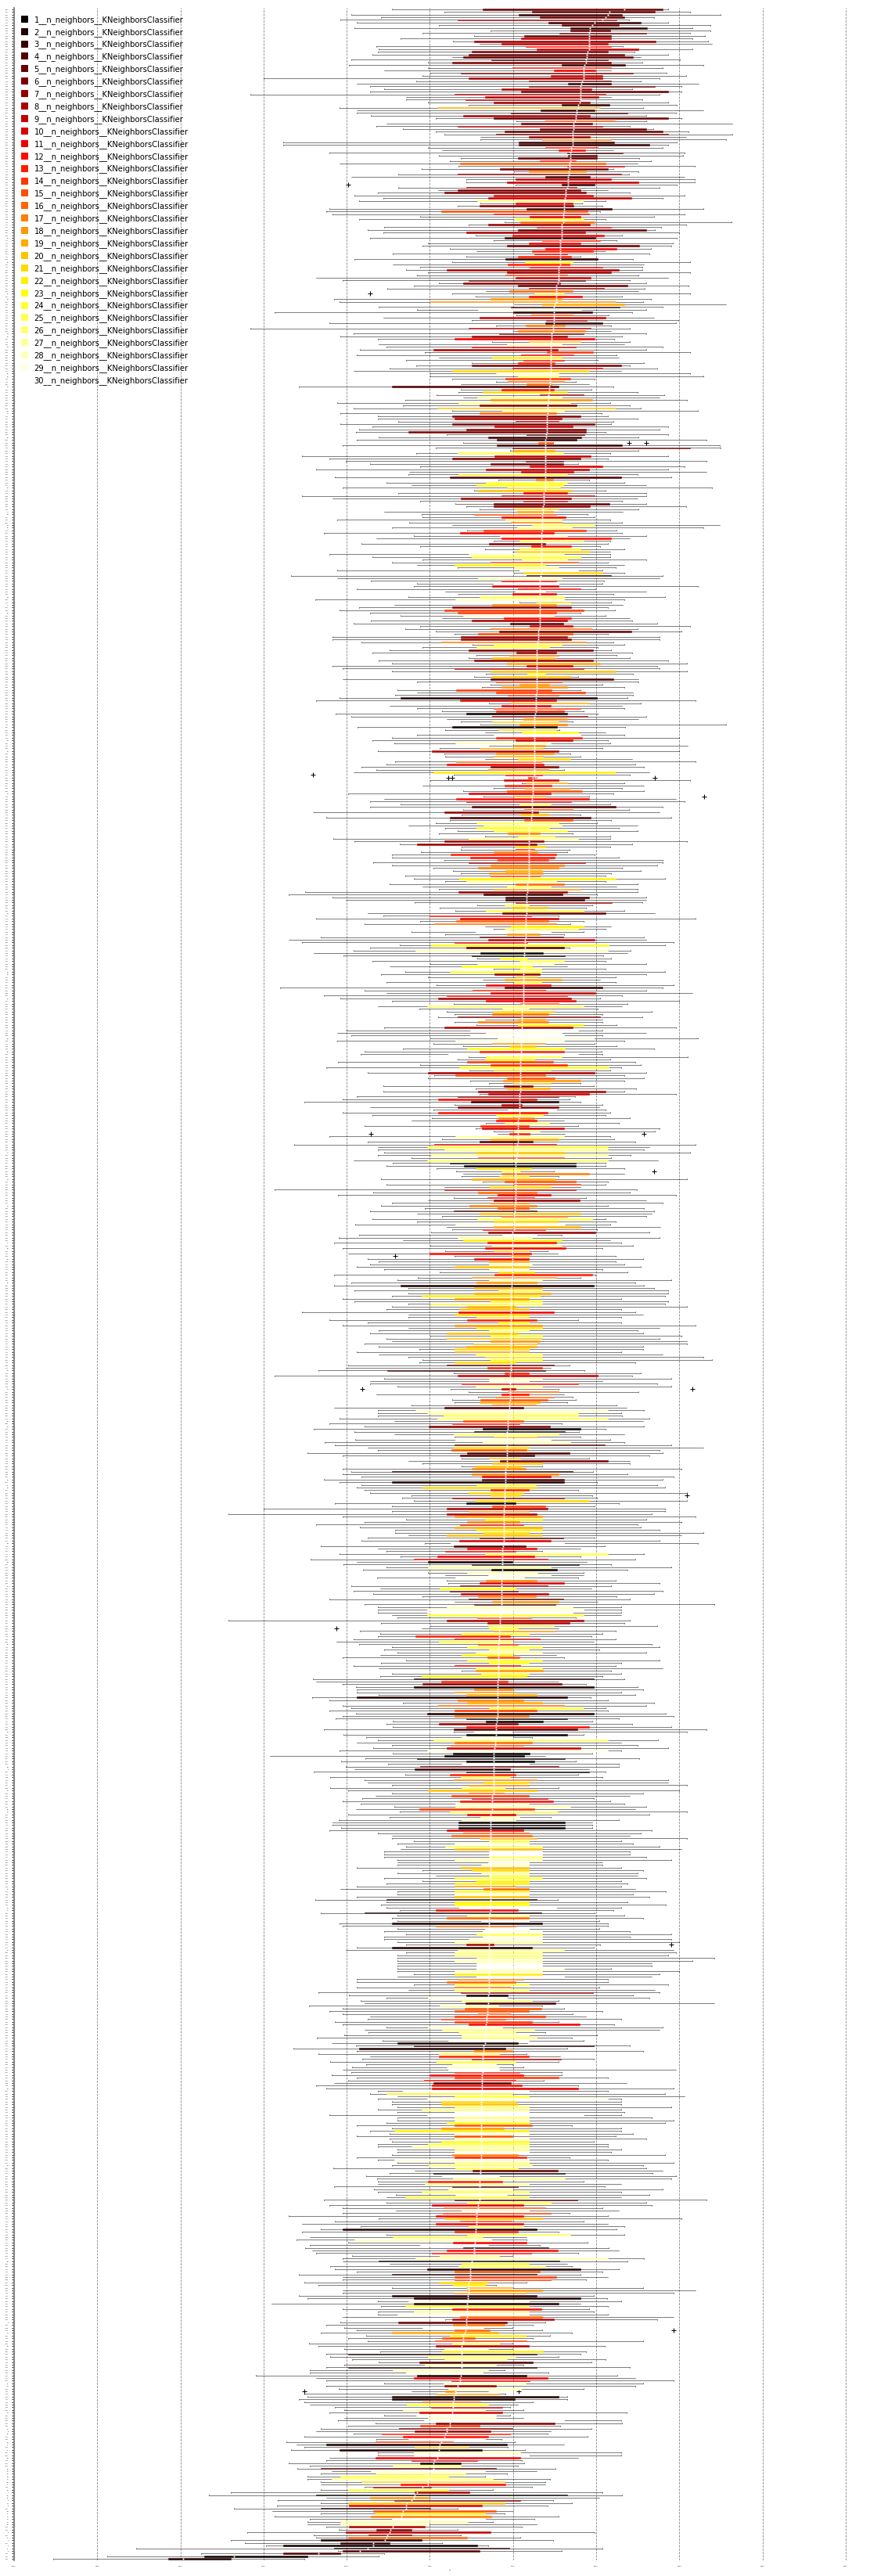

In [36]:
kfcv.plot_contest(all_folds=True, markersize=1, fontsize=2, figsize=(20,60), 
                  color_by='estimator__knn__n_neighbors', color_map='hot')

It appears there are rather mixed results, except the highest scores appear to occur with 1 to about 13 nearest neighbors. Although, they are still represented at the lowest levels as well.

# Reducing the number of pipeline combinations
This process can become time-intensive quickly. So, in the spirit of RandomizedGridSearchCV, I've included a random_combinations keyword argument to specify the number of available combinations and a random_comboination_seed that will be calculated similarly to duplicate results:

In [37]:
%%time 

import numpy as np

# Initialize nested k-fold cross-validation object
kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=3, 
                                      inner_loop_fold_count=3,
                                      shuffle_seed=3243,
                                      outer_loop_split_seed=45,
                                      inner_loop_split_seeds=[62, 207, 516],
                                      random_combinations=50,
                                      random_combination_seed=2374)

# Design combinatorial pipeline schematic
feature_count = X.shape[1]

pipeline_schematic = [
    {'scaler': {
            'min_max': {},
            'standard': {}
        }
    },
    {'transform': {
            'pca': {
                'n_components': [feature_count]
            }
        }         
    },
    {'feature_selection': {
            'select_k_best': {
                'k': range(1, feature_count+1)
            }
        }
    },
    {'estimator': {
            'knn': {
                'n_neighbors': range(1,31)
                }
        }
    }
]

# Perform nested k-fold cross-validation
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, scoring_metric='auc')

Outer Fold: 2 

681 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('transform', PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('feature_selection', SelectKBest(k=7, score_func=<function f_classif at 0x11a0209b0>)), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=22, p=2,
           weights='uniform'))])
710 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('transform', PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('feature_selection', SelectKBest(k=8, score_func=<function f_classif at 0x11a0209b0>)), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=21, p=2,
           weights='uniform

In [38]:
kfcv.fit(X.values, y.values, pipeline_schematic=pipeline_schematic, 
    best_inner_fold_pipeline_inds={2:681})


--------------------------------------------------------------------------------
Best pipeline: 904
--------------------------------------------------------------------------------
----------------------  ------------------------------------
Validation performance  Inner-loop scores
----------------------  ------------------------------------
                                    OF0       OF1       OF2
 min    0.7784            min    0.7765    0.7843    0.7321
 25%    0.7851            25%     0.786     0.803    0.7547
 50%    0.7918            50%    0.7954    0.8217    0.7774
 75%    0.7965            75%    0.8096    0.8237    0.7917
 max    0.8012            max    0.8237    0.8257    0.8061
----------------------  ------------------------------------
mean    0.7905           mean    0.7986    0.8106    0.7719
 std   0.01146            std   0.02376   0.02287    0.0373
----------------------  ------------------------------------
 OF0    0.8012            IF0    0.7954    0.8257   

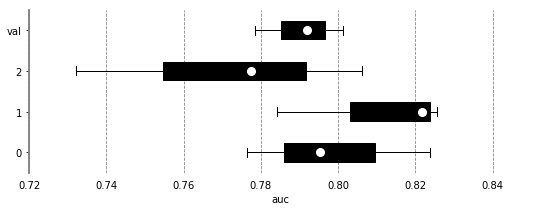

In [39]:
kfcv.plot_best_pipeline_scores()

The best pipeline has a slightly lower median validation score (0.7918 vs  0.7995) than that testing on all pipelines, though at about 1/15 of the time (8.68 s versus 2 min 15 s). 

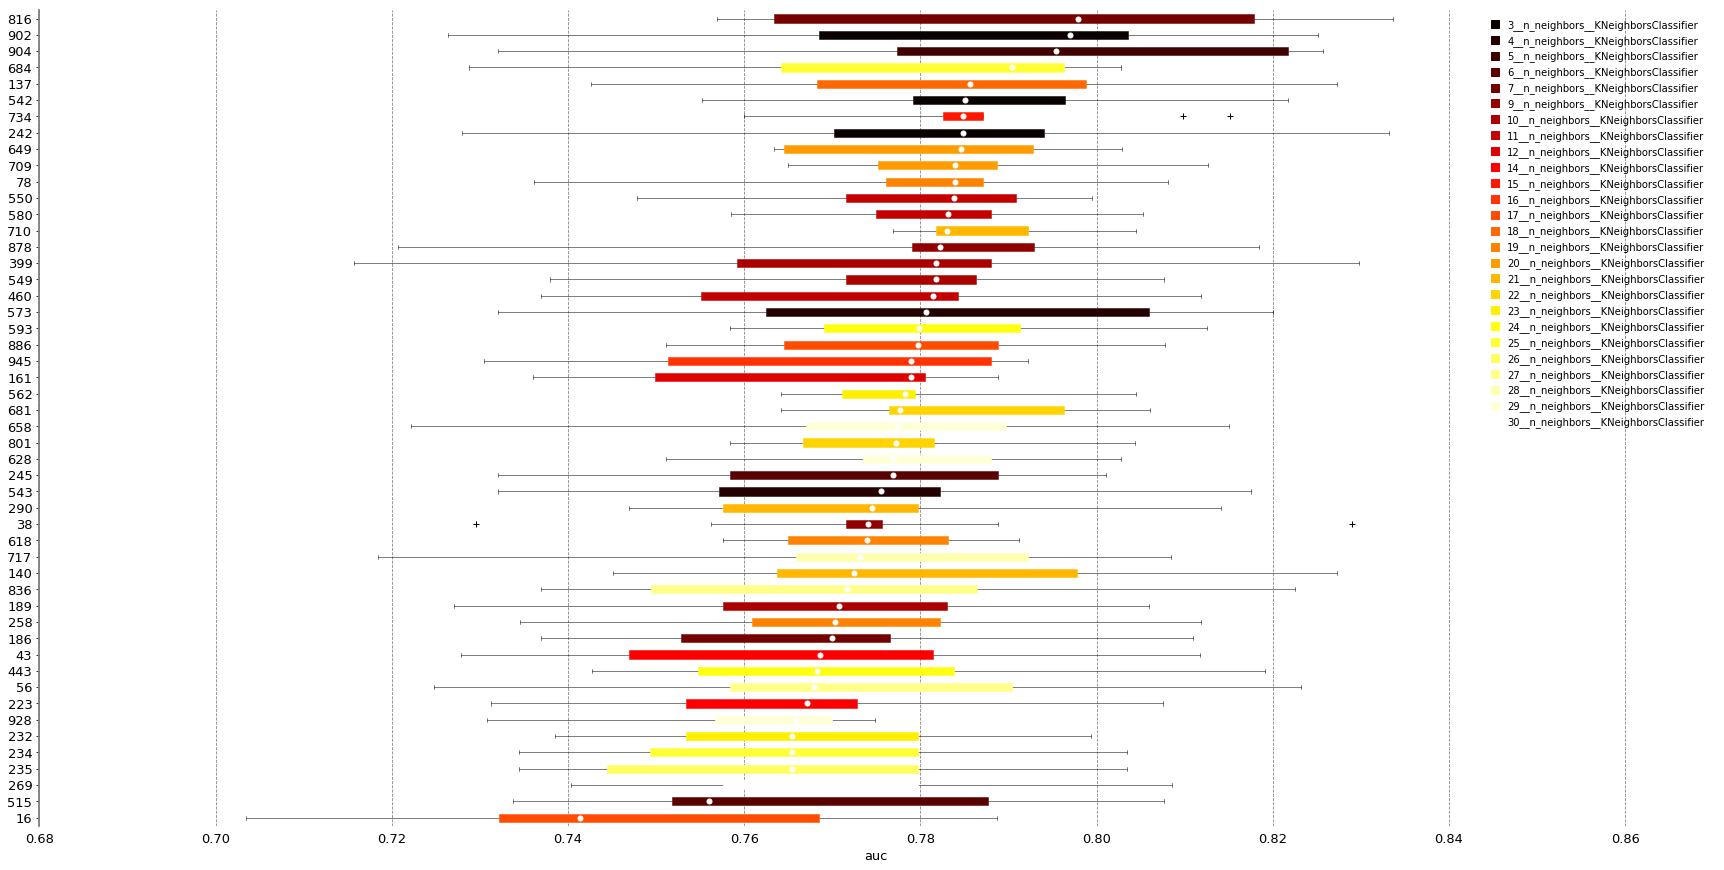

In [43]:
kfcv.plot_contest(all_folds=True, markersize=5, fontsize=13, figsize=(30,15), 
                  color_by='estimator__knn__n_neighbors', color_map='hot', legend_loc='best')

Having less pipelines certainly makes it easier to make these graphs look better.

# Accessing internal pipeline parameters
The best pipeline is automatically placed in the pipeline field of the nested k-fold cross-validation object (kfcv).

This object is a custom pyplearnr.OuterFoldTrainedPipeline object whose own pipeline field contains the actual trained sklearn.pipeline.Pipeline object. This object can be used to look at derived pipeline step parameters normally. Please see scikit-learn's documention of Pipeline objects for more information.

# Predicting survival with the optimal model
All one has to do to make a prediction is use the .predict() method.

Here's an example of predicting whether I would survive on the Titanic. I'm 33, would probably have one family member with me, might be Pclass1 (I'd hope), male, have a Ph.D (if that's what they mean by Dr.). I'm using the median Fare for Pclass 1 and arbitrary chose a city to have embarked from:

In [44]:
personal_stats = np.array([33, 1, 0, df[df['Pclass']==1]['Fare'].median(), 
                  0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0])

zip(personal_stats,X.columns)

[(33.0, 'Age'),
 (1.0, 'SibSp'),
 (0.0, 'Parch'),
 (60.287499999999994, 'Fare'),
 (0.0, 'Pclass_2'),
 (0.0, 'Pclass_3'),
 (1.0, 'Sex_male'),
 (1.0, 'Embarked_Q'),
 (0.0, 'Embarked_S'),
 (1.0, 'Title_Dr'),
 (0.0, 'Title_Military'),
 (0.0, 'Title_Miss'),
 (0.0, 'Title_Mr'),
 (0.0, 'Title_Mrs'),
 (0.0, 'Title_Noble'),
 (0.0, 'Title_Rev')]

In [45]:
kfcv.predict(personal_stats.reshape(1,-1))

array([1], dtype=uint8)

Looks like I survived!

Let's look at my predicted probability of surviving:

In [46]:
kfcv.predict_proba(personal_stats.reshape(1,-1))

array([[ 0.4,  0.6]])

I would have a 60% chance of survival.

## Summary
I've shown how to use pyplearnr to do model selection and validation among a diverse collection of pipelines, generated using a simple/intuitive/flexible combinatorial pipeline schematic input, using nested k-fold cross-validation.

Also, I've shown how to visualize the best model performance and that of all models in the inner-fold contests of each outer-fold, predict survival, and check the actual predicted probability according to the optimized pipeline.

I hope this proves to be a useful tool. 

Please let me know if you have any questions or suggestions about how to improve this tool, my code, the approach I'm taking, etc.